# Explore subreddit graph
Let's look at the graph of subreddits that we collected from comment cross-posting.

In [1]:
import pandas as pd
subreddit_comment_graph = pd.read_csv('../../data/reddit_data/comment_2019-01_cross_posting.gz', sep='\t', compression='gzip', index_col=False)
subreddit_comment_graph.drop('Unnamed: 0', axis=1, inplace=True)
print(subreddit_comment_graph.shape)
display(subreddit_comment_graph.head())

(28527789, 3)


,subreddit_i,subreddit_j,count
0,AskDocs,TooAfraidToAsk,0.003774
1,EverspaceGame,Minecraft,0.000624
2,EverspaceGame,MinecraftSwitch,0.035714
3,EverspaceGame,NintendoSwitch,0.000656
4,EverspaceGame,OXENFREE,0.028571


In [2]:
display(subreddit_comment_graph.sort_values('count', inplace=False, ascending=False).head())

,subreddit_i,subreddit_j,count
15498417,MusicalWritingPrompts,VerseBattles,1.0
7394202,DearBabby,iamamiwhoami,1.0
19073178,ShroomIdentify,sissypics,1.0
17963926,RandomAndNew,corinnakopf,1.0
17043156,PersonalAdvice,openbroke,1.0


In [3]:
## convert to weighted undirected network
from networkx import Graph
subreddit_graph = Graph()
edge_data = subreddit_comment_graph.apply(lambda x: (x.loc['subreddit_i'], x.loc['subreddit_j'], {'weight':x.loc['count']}), axis=1).values
subreddit_graph.add_edges_from(edge_data)
# for idx_i, data_i in subreddit_comment_graph.iterrows():
#     subreddit_graph.add_edge((data_i))

In [4]:
len(subreddit_graph)

59071

In [5]:
test_node = 'AmItheAsshole'
test_edges = list(subreddit_graph.neighbors(test_node))
print(test_edges[:10])

['cardistry', 'magicTCG', 'yugioh', 'HaveWeMet', 'TwoSentenceHorror', 'answers', 'dadjokes', 'findareddit', 'fireemblem', 'tipofmytongue']


### Get nearest neighbors
Let's start by looking for top-K neighbors for each advice subreddit.

In [9]:
import numpy as np
len(list(filter(lambda x: type(x) is float and np.isnan(x), subreddit_graph.nodes())))

0

In [11]:
advice_subreddits = ['Advice', 'AmItheAsshole', 'pcmasterrace', 'legaladvice', 'personalfinance']
top_k = 10
advice_subreddit_neighbor_data = []
for node_i in advice_subreddits:
    print(f'**** subreddit = {node_i} ****')
    neighbors_i = list(subreddit_graph.neighbors(node_i))
    neighbors_i = pd.DataFrame([
        neighbors_i,
        list(map(lambda x: subreddit_graph.get_edge_data(node_i, x)['weight'], neighbors_i))
    ], index=['neighbor', 'weight']).transpose()
    neighbors_i.sort_values('weight', inplace=True, ascending=False)
    top_k_neighbors_i = neighbors_i.head(top_k)
    display(top_k_neighbors_i)
    top_k_neighbor_data_i = neighbors_i.loc[:, ['neighbor']].assign(**{'subreddit' : node_i})
    advice_subreddit_neighbor_data.append(top_k_neighbor_data_i)
advice_subreddit_neighbor_data = pd.concat(advice_subreddit_neighbor_data, axis=0)

**** subreddit = Advice ****


,neighbor,weight
29,relationship_advice,0.015419
27,offmychest,0.012571
44,depression,0.01025
61,dating_advice,0.009391
17,NoStupidQuestions,0.00904
25,unpopularopinion,0.008972
146,AmItheAsshole,0.008605
4,legaladvice,0.008489
62,relationships,0.008075
144,rant,0.007669


**** subreddit = AmItheAsshole ****


,neighbor,weight
11,unpopularopinion,0.011298
66,relationship_advice,0.009141
73,Advice,0.008605
51,NoStupidQuestions,0.008415
179,TooAfraidToAsk,0.005994
79,rant,0.005797
35,TrueOffMyChest,0.005644
115,offmychest,0.005363
161,legaladvice,0.005104
257,confessions,0.004592


**** subreddit = pcmasterrace ****


,neighbor,weight
18,buildapc,0.032952
34,techsupport,0.015459
244,Amd,0.012332
167,Monitors,0.010835
139,MechanicalKeyboards,0.009976
58,gaming,0.009952
59,nvidia,0.008893
273,overclocking,0.00828
30,buildmeapc,0.007428
97,hardwareswap,0.007359


**** subreddit = legaladvice ****


,neighbor,weight
8,LegalAdviceUK,0.011506
33,personalfinance,0.010983
5,Advice,0.008489
45,NoStupidQuestions,0.006366
251,AmItheAsshole,0.005104
67,unpopularopinion,0.004556
35,AskDocs,0.00442
119,relationship_advice,0.003989
68,offmychest,0.003528
360,legaladviceofftopic,0.003355


**** subreddit = personalfinance ****


,neighbor,weight
73,legaladvice,0.010983
86,tax,0.010244
222,investing,0.007689
53,HomeImprovement,0.006899
106,jobs,0.005829
45,RealEstate,0.005463
7,CreditCards,0.005436
66,NoStupidQuestions,0.005387
91,Advice,0.004732
55,careerguidance,0.004564


Great! These subreddits identify different areas of expertise that could inform how questions are generated. 

Ex. for a comment in `legaladvice`, if someone has posted in `jobs` and `careerguidance` then they likely have more experience in answering legal questions.

### Test subreddit coverage in prior posts
Let's use the related subreddits and test the coverage among prior posts for the comment authors.

In [32]:
## load question data
from ast import literal_eval
from datetime import datetime
comment_data = pd.read_csv('../../data/reddit_data/subreddit_combined_comment_question_data.gz', sep='\t', compression='gzip', usecols=['subreddit', 'author', 'questions', 'created_utc'])
comment_data = comment_data[comment_data.loc[:, 'created_utc'].apply(lambda x: type(x) is int)]
comment_data = comment_data.assign(**{
    'questions' : comment_data.loc[:, 'questions'].apply(lambda x: literal_eval(x) if type(x) is str else ''),
    'date' : comment_data.loc[:, 'created_utc'].apply(lambda x: datetime.fromtimestamp(x))
})
print(comment_data.shape[0])
display(comment_data.head())
# cutoff data to match comment graph time: one month after comment graph
start_time = datetime(year=2019, month=2, day=1)
end_time = datetime(year=2019, month=3, day=1)
valid_comment_data = comment_data[(comment_data.loc[:, 'date'] >= start_time) & 
                                  (comment_data.loc[:, 'date'] <= end_time)]
# must include >= 1 question
question_comment_data = valid_comment_data[valid_comment_data.loc[:, 'questions'].apply(lambda x: len(x) > 0)]
## sample authors who ask questions
import numpy as np
np.random.seed(123)
subreddit_sample_size = 100
subreddit_sample_author_data = []
for subreddit_i, data_i in question_comment_data.groupby('subreddit'):
    sample_authors_i = np.random.choice(data_i.loc[:, 'author'].unique(), subreddit_sample_size, replace=False)
    sample_data_i = data_i[data_i.loc[:, 'author'].isin(sample_authors_i)].loc[:, ['subreddit', 'author']].drop_duplicates('author')
    subreddit_sample_author_data.append(sample_data_i)
subreddit_sample_author_data = pd.concat(subreddit_sample_author_data, axis=0)

4660479


,author,created_utc,subreddit,questions,date
0,grumpypantsoldman,1541030405,AmItheAsshole,[Who needs a crazy person in their lives?],2018-11-01 00:00:05
1,unknown_salmon,1541030426,Advice,[Do you think you could be bothered to have a ...,2018-11-01 00:00:26
2,vld-s,1541030467,AmItheAsshole,[],2018-11-01 00:01:07
3,Prepperpoints2Ponder,1541030470,personalfinance,[],2018-11-01 00:01:10
4,juliej891,1541030493,Advice,"[If it was me, I’d just let him do his thing w...",2018-11-01 00:01:33


In [33]:
print(subreddit_sample_author_data.shape[0])

500


In [ ]:
## collect data from comment file
from data_helpers import FileReader
import json
comment_file = '/local2/lbiester/pushshift/comments/RC_2018-12.zst'
sample_author_prior_comments = []
sample_author_prior_comment_count = 100
subreddit_sample_authors = subreddit_sample_author_data.loc[:, 'author'].unique()
# keep track of comments collected per author
# end collection when we get enough comments for everyone
subreddit_sample_author_counts = np.zeros(len(subreddit_sample_authors))
subreddit_sample_author_idx = dict(zip(subreddit_sample_authors, range(len(subreddit_sample_authors))))
for l in tqdm(FileReader(comment_file)):
    try:
        l_data = json.loads(l.strip())
        if(l_data['author'] in subreddit_sample_authors):
            author_idx = subreddit_sample_author_idx[l_data['author']]
            if(subreddit_sample_author_counts[author_idx] < sample_author_prior_comment_count):
                sample_author_prior_comments.append([l_data['author'], l_data['subreddit']])
                subreddit_sample_author_counts[author_idx] += 1
        if(all(subreddit_sample_author_counts >= sample_author_prior_comment_count)):
            break
#         ctr += 1
#         if(ctr % 1000000 == 0):
#             print(f'processed {ctr} comments')
    except Exception as e:
        print(e)
        break

14416901it [20:59, 11496.02it/s]

In [20]:
## TODO: get 1000 prior comments from all authors, test % coverage among related subreddits
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import load_reddit_api
reddit_auth_file = '../../data/auth_data/reddit_auth.csv'
reddit_api, pushshift_reddit_api = load_reddit_api(reddit_auth_file)

In [43]:
from tqdm import tqdm
author_comment_sample_count = 100
start_time = datetime(year=2019, month=2, day=1).timestamp()
end_time = datetime(year=2019, month=3, day=1).timestamp()
sample_author_posts = []
for sample_author_i in tqdm(subreddit_sample_author_data.loc[:, 'author'].unique()):
    author_comments_i = pushshift_reddit_api.search_comments(
        author=sample_author_i,
        after=start_time,
        before=end_time,
        limit=author_comment_sample_count,
    )
    sample_author_posts.extend(list(map(lambda x: x.__dict__(), author_comments_i)))
sample_author_posts = pd.DataFrame(sample_author_posts)

  0%|          | 0/500 [06:39<?, ?it/s]


Exception: Unable to connect to pushshift.io. Max retries exceeded.

### Old code

### Find communities
Let's look for consistent communities in the graph.

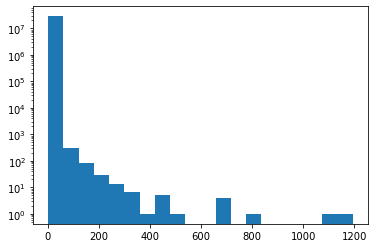

In [24]:
## plot edge weight distribution
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
subreddit_graph_edges = np.array(subreddit_graph.edges())
subreddit_graph_edge_weights = np.array([subreddit_graph.get_edge_data(*e)['weight'] for e in subreddit_graph_edges])
plt.hist(subreddit_graph_edge_weights, bins=20)
plt.yscale('log')
plt.show()

Most subreddits have weak connections. Let's try to prune those!

In [69]:
edge_weight_cutoff_pct = 99.9
edge_weight_cutoff = np.percentile(subreddit_graph_edge_weights, edge_weight_cutoff_pct)
print(f'edge weight cutoff = {edge_weight_cutoff}')
subreddit_graph_edges_cutoff = subreddit_graph_edges[np.where(subreddit_graph_edge_weights > edge_weight_cutoff)[0]]
print(f'{len(subreddit_graph_edges_cutoff)}/{len(subreddit_graph_edges)} edges retained after pruning')
prune_subreddit_graph = Graph()
for edge_i in subreddit_graph_edges_cutoff:
    weight_i = subreddit_graph.get_edge_data(*edge_i)['weight']
    prune_subreddit_graph.add_edge(*edge_i, weight=weight_i)

edge weight cutoff = 5.0
24737/28527789 edges retained after pruning


In [50]:
print(len(prune_subreddit_graph))

4941


In [51]:
## identify giant component
from networkx import connected_components
subreddit_connected_components = connected_components(prune_subreddit_graph)
subreddit_giant_component = list(sorted(subreddit_connected_components, key=len, reverse=True))[0]
subreddit_main_graph = subreddit_graph.subgraph(subreddit_giant_component)

In [52]:
print(len(list(connected_components(subreddit_graph))))
print(len(subreddit_main_graph))

1242
4645


In [53]:
import community # Louvain takes ~ 10 mins
# from networkx.algorithms.community.modularity_max import greedy_modularity_communities
# subreddit_graph_partition = list(greedy_modularity_communities(subreddit_graph))
subreddit_graph_partition = community.best_partition(subreddit_main_graph, weight='weight')

In [54]:
print(len(subreddit_graph_partition))

4645


In [55]:
# convert to community sets
from collections import defaultdict
subreddit_communities = defaultdict(set)
for subreddit_i, id_i in subreddit_graph_partition.items():
    subreddit_communities[id_i].add(subreddit_i)

In [56]:
subreddit_communities_by_size = list(sorted(subreddit_communities.keys(), key=lambda x: len(subreddit_communities.get(x)), reverse=True))
print(len(subreddit_communities[subreddit_communities_by_size[0]]))
# print(list(sorted(subreddit_communities[subreddit_communities_by_size[0]])))

2433


In [57]:
advice_subreddits = ['Advice', 'AmItheAsshole', 'pcmasterrace', 'legaladvice', 'personalfinance']
for advice_subreddit in advice_subreddits:
    print(subreddit_graph_partition[advice_subreddit])

6
6
3
6
6


Most of the advice subreddits end up in the same community.

### Normalize weights
Let's normalize the edge weights by what % of each subreddit's out-degree.

- A-B have 100 users
- A-C have 30 users
- B-C have 10 users

- A-B normalized =  1/2*(100/130 + 100/110) = 84%
- A-C normalized = 1/2*(30/130 + 30/40) = 49%
- B-C normalized = 1/2*(30/130 + 30/40) = 17%

In [74]:
# get combined weights
subreddit_combined_weights = {n : sum([prune_subreddit_graph.get_edge_data(n, n1)['weight'] for n1 in prune_subreddit_graph.neighbors(n)]) for n in prune_subreddit_graph.nodes()}
print(subreddit_combined_weights['Advice'])
# normalize lol
def compute_norm_edge_weight(n1, n2, weight, combined_weights):
    norm_weight = 0.5 * (weight / combined_weights[n1] + weight / combined_weights[n2])
    return norm_weight
subreddit_norm_edge_data = [(n1, n2, {'weight' : compute_norm_edge_weight(n1, n2, prune_subreddit_graph.get_edge_data(n1, n2)['weight'], subreddit_combined_weights)}) for n1, n2 in prune_subreddit_graph.edges()]
import networkx
norm_weight_subreddit_graph = networkx.from_edgelist(subreddit_norm_edge_data)

8343


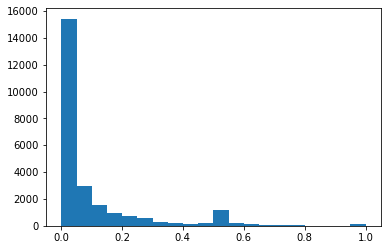

In [78]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
norm_weights = [norm_weight_subreddit_graph.get_edge_data(*e)['weight'] for e in norm_weight_subreddit_graph.edges()]
plt.hist(norm_weights, bins=20)
plt.show()

Most subreddits have weak cross-posting connections. We also have a bump around 0.5, suggesting that some subreddits with low degree have strong connections with half of their neighbors.

Next step: let's look for the top-K neighbors for each of the subreddits of interest.

In [81]:
advice_subreddits = ['Advice', 'AmItheAsshole', 'personalfinance', 'legaladvice', 'pcmasterrace']
top_k = 10
for subreddit_i in advice_subreddits:
    neighbors_i = norm_weight_subreddit_graph.neighbors(subreddit_i)
    neighbor_weights_i = [(n_j, norm_weight_subreddit_graph.get_edge_data(subreddit_i, n_j)['weight']) for n_j in neighbors_i]
    neighbor_weights_i = list(sorted(neighbor_weights_i, key=lambda x: x[1], reverse=True))
    print(f'subreddit={subreddit_i}, neighbors={neighbor_weights_i[:top_k]}')

subreddit=Advice, neighbors=[('helpme', 0.500659235287067), ('MMFB', 0.5004195133644972), ('domesticviolence', 0.5004195133644972), ('Adulting', 0.5004195133644972), ('LifeAdvice', 0.36459525132664294), ('work', 0.32577909624835194), ('PlasticSurgery', 0.2817893743257821), ('education', 0.2504195133644972), ('MadeMeSmile', 0.25035958288385474), ('CleaningTips', 0.23112881365308552)]
subreddit=AmItheAsshole, neighbors=[('pettyrevenge', 0.13075757033217555), ('skiing', 0.11635142170108333), ('MaliciousCompliance', 0.10655223298336075), ('badroommates', 0.0914502094747019), ('entitledparents', 0.06441483308190142), ('Herpes', 0.04444506718603315), ('TalesFromYourServer', 0.041289075088623915), ('vancouver', 0.04045378339917514), ('relationship_advice', 0.039799374560282694), ('omad', 0.0394283447780064)]
subreddit=personalfinance, neighbors=[('Birmingham', 0.5007266385699753), ('consulting', 0.5005813108559802), ('Dashcam', 0.5005813108559802), ('nashville', 0.5005086469989827), ('tulsa',

Most of the top-K neighbors are relevant, but some of them are definitely off the mark:
- `Advice`: `Adulting` relevant, `PlasticSurgery` irrelevant
- `AmItheAsshole`: `pettyrevenge` relevant, `skiing` irrelevant
- `personalfinance`: `consulting` relevant, `Birmingham` irrelevant
- `legaladvice`: `AusLegal` relevant, `Charlotte` irrelevant
- `pcmasterrace`: `LinusTechTips` relevant, `nier` irrelevant